<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10
## <center> Часть 5. Xgboost и Hyperopt, тюнинг параметров

## <center> Прогнозирование задержек вылетов

Ваша задача – побить как минимум 2 бенчмарка в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен второй – с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит градиентный бустинг. Скорее всего Xgboost, но тут у нас еще немало категориальных признаков...

<img src='../../img/xgboost_meme.jpg' width=40% />

**Подключаем библиотеки и загружаем данные. Используем [log_progress](https://github.com/alexanderkuk/log-progress) для отслеживания итераций в циклах.**

In [8]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
Month                100000 non-null object
DayofMonth           100000 non-null object
DayOfWeek            100000 non-null object
DepTime              100000 non-null int64
UniqueCarrier        100000 non-null object
Origin               100000 non-null object
Dest                 100000 non-null object
Distance             100000 non-null int64
dep_delayed_15min    100000 non-null object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


In [5]:
train.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

Второй бенчмарк, представленный в рейтинге соревнования, был получен так:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, вы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!

In [26]:
from sklearn.metrics import roc_auc_score

Функция для перекодирования данных для использования в xgboost

In [6]:
def feater_encoder(train, test):
    '''
    Возвращает перекодированные: train (без целевого признака), test и целевой признак y_train
    '''
    
    lab_enc = LabelEncoder()
    
    data = pd.concat([train.copy().drop('dep_delayed_15min', axis=1), test.copy()])
    
    data['Route'] = data['Origin'] + '-->' + data['Dest']
    data['Month'] = lab_enc.fit_transform(data['Month'])
    data['DayofMonth'] = lab_enc.fit_transform(data['DayofMonth'])
    data['DayOfWeek'] = lab_enc.fit_transform(data['DayOfWeek'])
    data['UniqueCarrier'] = lab_enc.fit_transform(data['UniqueCarrier'])
    data['Origin'] = lab_enc.fit_transform(data['Origin'])
    data['Dest'] = lab_enc.fit_transform(data['Dest'])
    data['Route'] = lab_enc.fit_transform(data['Route'])
    #data['DepTime'] = data['DepTime'] // 100    # результат не улучшают
    y_train = train['dep_delayed_15min'].map({'Y':1, 'N':0})
    
    return data[:train.shape[0]], data[train.shape[0]:], y_train

Сделаем (протестируем) кросс-валидацию на параметрах из предыдущих частей

### Подготовим все данные.

Сначала - обучающую выборку (а заодно и тестовую).

In [12]:
X_train, X_test, y_train = feater_encoder(train, test)

Разделим данные на обучающую и отложенную выборки в отношении 7:3. Инициализируем соотв. объекты DMatrix dtrain и dvalid.

In [20]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train,
                                                    test_size=0.3, stratify=y_train, random_state=17)
dtrain = xgb.DMatrix(X_train_part, y_train_part)
dvalid = xgb.DMatrix(X_valid, y_valid)

In [29]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [54]:
def score(params):
    print("Training with params:")
    print(params)
        
    params['max_depth'] = int(params['max_depth'])
   
    xgb_model = xgb.train(params, dtrain, params['num_round'])
    xgboost_valid_pred = xgb_model.predict(dvalid)
    auc_score = roc_auc_score(y_valid, xgboost_valid_pred)
    print("\tAUC_Score {0}\n\n".format(auc_score))
    return {'loss': 1 - auc_score, 'status': STATUS_OK}

In [55]:
def optimize(trials):
    space = {
             'num_round': 100,
             'learning_rate': hp.quniform('eta', 0.05, 0.5, 0.05),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'colsample_bytree': hp.quniform('colsample_bytree', 0.4, 1, 0.05),
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10)
    return best

In [39]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:
{'colsample_bytree': 0.4, 'eval_metric': 'auc', 'gamma': 0.6, 'learning_rate': 0.35000000000000003, 'max_depth': 13.0, 'min_child_weight': 8.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.6000000000000001}
	AUC_Score 0.7135346466666039


Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.54, 'learning_rate': 0.2, 'max_depth': 9.0, 'min_child_weight': 8.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9}
	AUC_Score 0.746196392458983


Training with params:
{'colsample_bytree': 0.9, 'eval_metric': 'auc', 'gamma': 0.76, 'learning_rate': 0.5, 'max_depth': 8.0, 'min_child_weight': 3.0, 'nthread': 4, 'num_round': 100, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.9}
	AUC_Score 0.7176055249397393


Training with params:
{'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.75, 'learning_rate': 0.35000000000000003, 'max_depth': 10.

{'colsample_bytree': 0.9,
 'eta': 0.2,
 'gamma': 0.54,
 'max_depth': 9.0,
 'min_child_weight': 8.0,
 'subsample': 0.9}

In [40]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['eval_metric'] = 'auc'
best_params['objective'] = 'binary:logistic'
best_params['nthread'] = 4
best_params['silent'] = 1

In [41]:
dtrain_full = xgb.DMatrix(X_train, y_train)

In [42]:
%%time
xgbCvResult = xgb.cv(best_params, dtrain_full, 
                      num_boost_round=500,  
                      nfold=3, early_stopping_rounds=50)


Wall time: 12.2 s


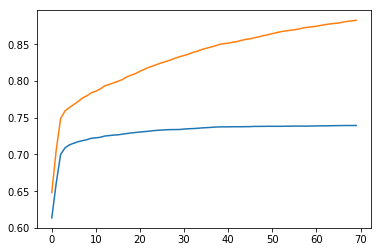

In [44]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['test-auc-mean'])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult['train-aucX_test-mean']);

In [47]:
best_num_round = np.argmax(xgbCvResult['test-auc-mean'])
best_num_round

69

### Сделаем прогноз для всей тестовой выборки и подготовим submission для посылки на kaggle

обучим модель

In [50]:
%%time
bestXgb = xgb.train(best_params, dtrain_full, num_boost_round=best_num_round)

Wall time: 2.83 s


In [52]:
dtest = xgb.DMatrix(X_test)
xgboost_test_pred = bestXgb.predict(dtest)

In [53]:
pd.Series(xgboost_test_pred, name='dep_delayed_15min').to_csv('data/5_xgboost_2.csv', index_label='id', header=True)

## **Текущий анализ:**

- **Получили на kaggle AUC = 0.72397**
- даже меньше предыдущего (было AUC = 0.72972). Для хорошего результата нужно больше времени потратить на подбор. Цель здесь - в основном демонстрация.

## Сделаем еще один подбор

In [ ]:
def score(params):
    #print("Training with params:")
    #print(params)
        
    params['max_depth'] = int(params['max_depth'])
   
    xgb_model = xgb.train(params, dtrain, params['num_round'])
    xgboost_valid_pred = xgb_model.predict(dvalid)
    auc_score = roc_auc_score(y_valid, xgboost_valid_pred)
    #print("\tAUC_Score {0}\n\n".format(auc_score))
    return {'loss': 1 - auc_score, 'status': STATUS_OK}

In [ ]:
def optimize(trials):
    space = {
             'num_round': 170,
             'learning_rate': hp.quniform('eta', 0.05, 0.5, 0.05),
             'max_depth': hp.quniform('max_depth', 3, 14, 1),
             'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
             'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma': hp.quniform('gamma', 0.5, 1, 0.01),
             'eval_metric': 'auc',
             'objective': 'binary:logistic',
             'nthread' : 4,
             'silent' : 1
             }
    
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)
    return best

In [56]:
%%time
trials = Trials()
best_params = optimize(trials)
best_params

Wall time: 5min 9s


In [57]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['eval_metric'] = 'auc'
best_params['objective'] = 'binary:logistic'
best_params['nthread'] = 4
best_params['silent'] = 1

In [59]:
%%time
bestXgb = xgb.train(best_params, dtrain_full, num_boost_round=170)

Wall time: 7.48 s


In [60]:
dtest = xgb.DMatrix(X_test)
xgboost_test_pred = bestXgb.predict(dtest)

In [61]:
pd.Series(xgboost_test_pred, name='dep_delayed_15min').to_csv('data/6_xgboost_3.csv', index_label='id', header=True)

### Анализ:

AUC на keggle - 0.72877, уже близко к результату на catboost